In [22]:
import pandas as pd
import json
import matplotlib.pyplot as plt #Для визуализации

In [23]:
df_full = pd.read_csv("data/init_data.csv")
df_full.head(2)

C:\Users\glaz\AppData\Local\Temp\ipykernel_24396\263171808.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("data/init_data.csv")


,addOkved,address,chiefs,dateLiquid,dateOgrn,dateReg,email,fullName,inn,kpp,...,okato,okfs,okogu,oktmo,socialMedia,opfType,reports,incomeTotal,incomeDetail,incomeRank
0,"[{'code': '72.4', 'name': 'Деятельность по соз...","422430, РЕСПУБЛИКА ТАТАРСТАН, ГОРОД БУИНСК, УЛ...","[{'name': 'ХАЛИКОВ РАШИТ РИНАТОВИЧ', 'title': ...",{'$date': '2012-12-17T00:00:00.000Z'},{'$date': '2010-03-03T00:00:00.000Z'},NaN,NaN,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""ИНФОРМАЦИОННО-КОНС...",1.614010e+09,161401001.0,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,[],0.0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...
1,"[{'code': '67.20.2', 'name': 'Деятельность спе...","430030, РЕСПУБЛИКА МОРДОВИЯ, ГОРОД САРАНСК, УЛ...","[{'name': 'ПУЗАНОВ ВЛАДИМИР ВЛАДИМИРОВИЧ', 'ti...",{'$date': '2014-11-10T00:00:00.000Z'},{'$date': '2010-05-11T00:00:00.000Z'},NaN,NaN,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""МЕЖРЕГИОНАЛЬНЫЙ НА...",1.327011e+09,132701001.0,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,"[{'type': 'Заявление', 'reportId': '19445801',...",0.0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...


Формируем признаки:
1. totalSumGrants (тип floats) - сумма грантов и субсидий
2. totalSumContract (тип floats) - сумма контрактов

Исходные данные для формирования признаков - признак incomeDetail. 

In [24]:
# Функция для вычисления суммы totalSumGrants для "grants" и "fedSubsidies"
def calculate_total_sum_grant(json_string):
    #Аргумент "json_string" - строка с данными о сумме и количеству грантов, субсидий и контрактов
    try:
        # Преобразование JSON-строки        
        income_detail_dict = eval(json_string)
        # Получение значений totalSum для "grants" и "fedSubsidies"
        grants_total_sum = income_detail_dict.get("grants", {}).get("totalSum", 0)
        fed_subsidies_total_sum = income_detail_dict.get("fedSubsidies", {}).get("totalSum", 0) 
        # Возвращение суммы totalSumGrants типа float
        return float(grants_total_sum) + float(fed_subsidies_total_sum)
    except:
        return 0

# Функция для вычисления суммы totalSum для "grants" и "fedSubsidies"
def calculate_total_sum_contract(json_string):
    #Аргумент "json_string" - строка с данными о сумме и количеству грантов, субсидий и контрактов
    try:
        # Преобразование JSON-строки        
        income_detail_dict = eval(json_string)
        # Получение значений totalSum для контрактов: contracts44, contracts94, contracts223
        total_sum_44 = income_detail_dict.get("contracts44", {}).get("totalSum", 0)
        total_sum_94 = income_detail_dict.get("contracts94", {}).get("totalSum", 0)
        total_sum_223 = income_detail_dict.get("contracts223", {}).get("totalSum", 0)
        # Возвращение суммы totalSumContract типа float
        return float(total_sum_44) + float(total_sum_94) + float(total_sum_223)
    except:
        return 0

# Формирование признаков totalSumGrants и totalSumContract
df_full['totalSumGrants'] = df_full['incomeDetail'].apply(calculate_total_sum_grant)
df_full['totalSumContract'] = df_full['incomeDetail'].apply(calculate_total_sum_contract)

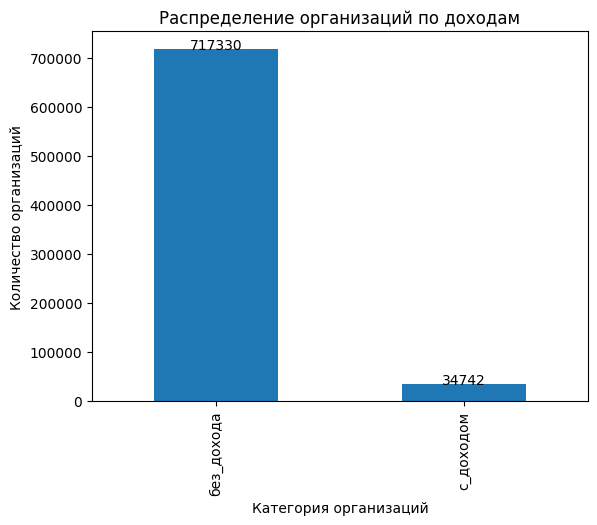

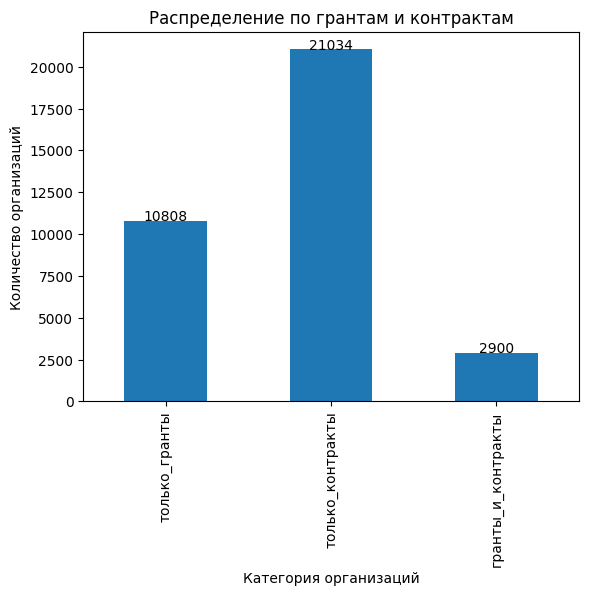

In [25]:
#Визуализация данных о распределении организаций по доходам

# Распределение организаций по доходам
df_full['без_дохода'] = df_full['incomeTotal'].apply(lambda x: 1 if x == 0 else 0)
df_full['с_доходом'] = df_full['incomeTotal'].apply(lambda x: 1 if x > 0 else 0)

ax = df_full[['без_дохода', 'с_доходом']].sum().plot(kind='bar')
plt.xlabel('Категория организаций')
plt.ylabel('Количество организаций')
plt.title('Распределение организаций по доходам')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center')

plt.show()

# Распределение по грантам и контрактам
df_full['только_гранты'] = ((df_full['totalSumGrants'] > 0) & (df_full['totalSumContract'] == 0)).astype(int)
df_full['только_контракты'] = ((df_full['totalSumGrants'] == 0) & (df_full['totalSumContract'] > 0)).astype(int)
df_full['гранты_и_контракты'] = ((df_full['totalSumGrants'] > 0) & (df_full['totalSumContract'] > 0)).astype(int)

ax = df_full[['только_гранты', 'только_контракты', 'гранты_и_контракты']].sum().plot(kind='bar')
plt.xlabel('Категория организаций')
plt.ylabel('Количество организаций')
plt.title('Распределение по грантам и контрактам')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center')

plt.show()

# Удаление временных столбцов
df_full.drop(['без_дохода', 'с_доходом', 'только_гранты', 'только_контракты', 'гранты_и_контракты'], axis=1, inplace=True)

In [26]:
#Заменим значения ячеек признаков incomeTotal, totalSumGrants, totalSumContract со значения суммы на бинарное значение: 1 - есть доход, 0 - не дохода.
df_full['incomeTotal'] = df_full['incomeTotal'].apply(lambda x: 1 if x > 0 else 0)
df_full['totalSumGrants'] = df_full['totalSumGrants'].apply(lambda x: 1 if x > 0 else 0)
df_full['totalSumContract'] = df_full['totalSumContract'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
# Сохранение DataFrame в файл CSV
df_full.to_csv('data/target_data.csv', index=False)